#Imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

import csv 
import re

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, mean_squared_error
from sklearn.decomposition import TruncatedSVD

import warnings
warnings.filterwarnings("ignore")

#Data Pre-processing

We preform some simple pre-processings by reading the train and test.csv files into dataframes and split dataframe into data and labels

In [2]:
train_corpus = pd.read_csv('train.csv')
test_corpus = pd.read_csv('test.csv')

X_train, y_train = train_corpus['Text'], train_corpus['Category']
X_test, y_test = test_corpus['Text'], test_corpus['Category']

enc = LabelEncoder()


### Exploratory Data Analysis


Constructing a feature vector for each article in the entire dataset. We report the number of articles and the number of extracted features. 5 examples articles and their extracted features are displayed in a dataframe.

In [3]:
train_documents = train_corpus['Text']
test_documents = test_corpus['Text']
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(test_documents)
vector = vectorizer.transform(test_documents)

print("Total Number of Documents: " +  str(vector.shape[0]))
print("total Extracted Features: " + str(vector.shape[1]))
example_articles = train_corpus['Text'].iloc[:5].tolist()
example_vectorizer = TfidfVectorizer()
values = []
for article in example_articles:
  iterable_article = [article]
  example_vectorizer.fit(iterable_article)
  features = example_vectorizer.get_feature_names_out()
  values.append([article, features])

example_df = pd.DataFrame(values, columns= ['Article', 'Extracted Features'])
print("5 Articles with related extracted Features using TF-IDF")
example_df.head()

Total Number of Documents: 106
total Extracted Features: 6408
5 Articles with related extracted Features using TF-IDF


,Article,Extracted Features
0,lifestyle governs mobile choice faster better ...,"[000, 14, 2003, 25, 29, 45, able, across, acti..."
1,french honour director parker british film dir...,"[2003, alan, also, artist, artistic, arts, awa..."
2,fockers fuel festive film chart comedy meet fo...,"[12, 121, 165, 19, 1m, 2003, 23, 24, 26, 2m, 3..."
3,housewives lift channel 4 ratings debut us tel...,"[11, 12, 20, 2002, 2004, 2005, 28, area, attra..."
4,u2 desire number one u2 three prestigious gram...,"[10, 12, 125, 17, 1978, 1979, 1980, 1985, 1987..."



#### Conducting term frequency analysis

Here we plot the top-50 term frequency distribution across the entire dataset. 

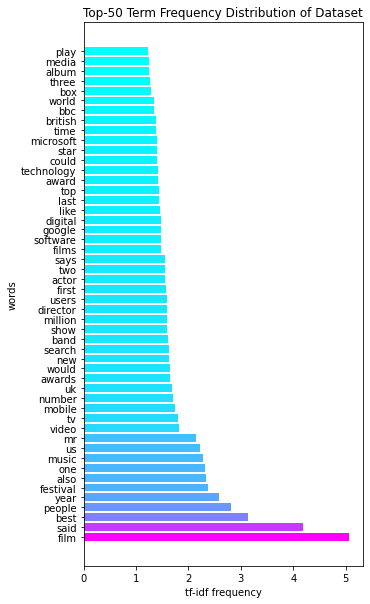

In [4]:
frequencies = sorted(list(zip(vectorizer.get_feature_names(), X.sum(0).getA1())), key=lambda x: x[1], reverse=True)[:50]
freq_vals = np.asarray(list(zip(*frequencies))[1])
freq_text = np.asarray(list(zip(*frequencies))[0])
plt.figure(figsize=(5,10))
my_cmap = plt.get_cmap("cool")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
plt.barh(freq_text, freq_vals, color=my_cmap(rescale(freq_vals)))
plt.title("Top-50 Term Frequency Distribution of Dataset")
plt.xlabel("tf-idf frequency")
plt.ylabel("words")
plt.show()


Here we plot the term frequency distribution for respective classes (tech & entertainment) of the articles.

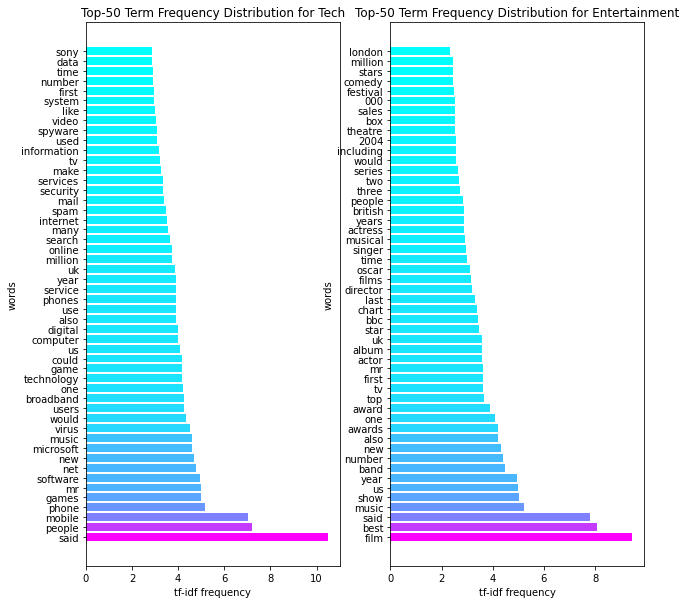

In [5]:
tech_corpus = train_corpus.loc[train_corpus['Category'] == 'tech']
ent_corpus = train_corpus.loc[train_corpus['Category'] == 'entertainment']


X_tech = vectorizer.fit_transform(tech_corpus['Text'])
tech_frequencies = sorted(list(zip(vectorizer.get_feature_names(), X_tech.sum(0).getA1())), key=lambda x: x[1], reverse=True)[:50]
X_ent = vectorizer.fit_transform(ent_corpus['Text'])
ent_frequencies = sorted(list(zip(vectorizer.get_feature_names(), X_ent.sum(0).getA1())), key=lambda x: x[1], reverse=True)[:50]

freq_tech_vals = np.asarray(list(zip(*tech_frequencies))[1])
freq_tech_text = np.asarray(list(zip(*tech_frequencies))[0])

freq_ent_vals = np.asarray(list(zip(*ent_frequencies))[1])
freq_ent_text = np.asarray(list(zip(*ent_frequencies))[0])

f = plt.figure(figsize=(10,10))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
my_cmap = plt.get_cmap("cool")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
ax1.barh(freq_tech_text, freq_tech_vals, color=my_cmap(rescale(freq_vals)))
ax1.set_title("Top-50 Term Frequency Distribution for Tech")
ax1.set_xlabel("tf-idf frequency")
ax1.set_ylabel("words")

ax2.barh(freq_ent_text, freq_ent_vals, color=my_cmap(rescale(freq_vals)))
ax2.set_title("Top-50 Term Frequency Distribution for Entertainment")
ax2.set_xlabel("tf-idf frequency")
ax2.set_ylabel("words")
plt.show()

Here we plot the class distribution of the articles.

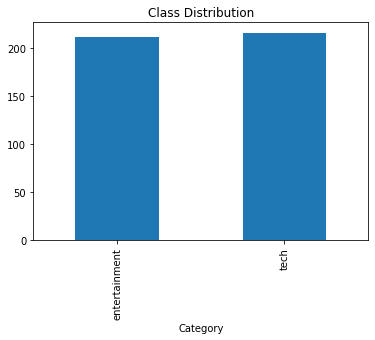

In [6]:
def get_class_dist(df, class_type):
    return df.pivot_table(index=class_type, aggfunc='size').plot(kind='bar', title='Class Distribution') 

get_class_dist(train_corpus, 'Category')
plt.show()



### Learning Classification Models


*Describe the effect of the regularization parameter $λ$ on the outcome in terms of bias and variance. Report the plot generated for specific $λ$ values with training loss on the y-axis versus $λ$ on the x-axis to support your claim.*

As the lambda value increases for logistic regression, the bias increases and the variance decreases. This is because in $l2$ regularization, lambda is the penalization hyperparameter, and as the value of lambda increases the penalization becomes more severe. This result increased biased to the training data and lower generality (variance) of the model; this phenomena is reflected in the MSE Loss inversely declines.

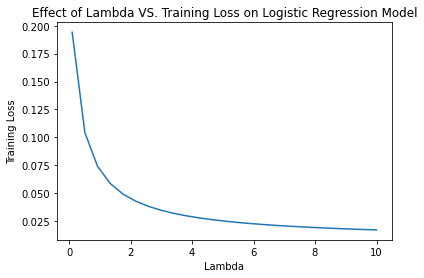

In [7]:
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(train_corpus.Text)
y_train = enc.fit_transform(train_corpus.Category)

X_test = vectorizer.transform(test_corpus.Text)
y_test = enc.transform(test_corpus.Category)

lambda_var = list(np.linspace(0.1,10.0,25))
results = []
for i in range(len(lambda_var)):
    LR = LogisticRegression(C = lambda_var[i] ).fit(X_train, y_train)
    y_pred = LR.predict_proba(X_test)
    results.append(mean_squared_error(y_test,y_pred[:,1]))
plt.plot(lambda_var, results)
plt.xlabel("Lambda")
plt.ylabel("Training Loss")
plt.title("Effect of Lambda VS. Training Loss on Logistic Regression Model")
plt.show()

*Which list of words describe the two classes better?*

The two lists have nine words in common and eleven words that are different. We think that the Top 20 words with most [list 1] identifiable words is better than the list with [list 2] maximised 
probability even with list 1 containing general words that may not be entriely relevant to either category such as "said" and "mr". This is because list 1 has a better spread of words to describe both categories whereas 
list 2 is extremely tech heavy, having few words to describe entertainment.

In [8]:
def get_top20():
  train_vector = vectorizer.fit_transform(train_corpus.Text)
  nb = MultinomialNB()
  nb.fit(train_vector, train_corpus.Category)
  pos = nb.feature_log_prob_[0,:]
  neg = nb.feature_log_prob_[1,:]
  distributions = []
  words = []
  ans = []
  for i in range(len(pos)):
      if pos[i] > neg[i]:
          ans.append(pos[i])
      else:
          ans.append(neg[i])
  ans = np.array(ans)
  ans_sorted = ans.argsort()[::-1]
  
  print('Top 20 Most Identifiable Words Over Technology and Entertainment:\n')
  print(np.take(vectorizer.get_feature_names(),ans_sorted[:20]))
  print("\n")
  print('Top 20 Words With Maximized Probability Over Technology and Entertainment:\n')
  quantMax = (((nb.feature_log_prob_[0,:] / nb.feature_log_prob_[1,:])-1)**2).argsort()[::-1]
  distributions.append(np.take((((nb.feature_log_prob_[0,:] / nb.feature_log_prob_[1,:])-1)**2), quantMax[:20]))
  print(np.take(vectorizer.get_feature_names(),quantMax[:20]))
  return words, distributions

words, distributions = get_top20()

Top 20 Most Identifiable Words Over Technology and Entertainment:

['film' 'said' 'best' 'people' 'mobile' 'software' 'games' 'phone' 'net'
 'show' 'band' 'users' 'music' 'technology' 'mr' 'microsoft' 'year'
 'awards' 'virus' 'us']


Top 20 Words With Maximized Probability Over Technology and Entertainment:

['mobile' 'software' 'games' 'users' 'net' 'microsoft' 'technology'
 'phone' 'virus' 'broadband' 'film' 'computer' 'phones' 'band' 'spam'
 'best' 'mail' 'use' 'online' 'firms']



We first carry out some preprocessing on the data set. The class labels of both the train and test data are endocded. For our train corpus we use a CounterVectorizer() to tokenize the data of both the train and test sets

In [9]:
X_train, y_train = train_corpus['Text'], train_corpus['Category']
X_test, y_test = test_corpus['Text'], test_corpus['Category']

# Using a label encoder for class labels of training(y_train) and testing(y_test) sets.
Encoder = LabelEncoder()
y_train = Encoder.fit_transform(y_train)
y_test =  Encoder.transform(y_test)

# Using a CountVectorizer to tokenize the data in the train_corpus
vectorizer = CountVectorizer()
x_train_count = vectorizer.fit_transform(X_train)
x_test_count = vectorizer.transform(X_test)

During the exploratory data analysis we found that the dataset has 13518 extracted features. We want to preform dimmesion reduction to a 2d space before fitting our SVM model. As the data is a sparse matrix, we use TruncatedSVD which is a PCA-like dimensonality reduction technique. We set the desired components to 2 (default of TruncatedSVD()). We can now fit our TruncatedSVD() to the x_train_count and reduce the training and test data to 2 dimensions.

In [10]:
#instantiation of TruncatedSVD object
tSVD=TruncatedSVD(n_components=2)

# fitting tSVD using the tokenized training data and transforming the training and test sets
x_train_tSVD = tSVD.fit_transform(x_train_count)
x_test_tSVD = tSVD.transform(x_test_count)

Here we instantiate a soft-margin $(c=0.5)$ linear SVC and fit it to our 2d training data and training labels.

In [11]:
#instantiate soft margin SVC, kernel is linear and misclasification penalty C=0.5.
clf=SVC(kernel='linear', C=0.5)
clf.fit(x_train_tSVD, y_train)
y_pred=clf.predict(x_test_tSVD)

#printing out some evaluation metrics for our model
print('Evaluation Metrics for soft-Margin linear SVM')
print('----------------------------------------------')
print('Accuracy score: ' + str(accuracy_score(y_pred, y_test)))
print('F1 score: ' + str(f1_score(y_test, y_pred, average='macro')))
print('Recall score: ' + str(recall_score(y_test, y_pred, average='macro')))
print('Precision score: ' + str(precision_score(y_test, y_pred, average='macro')))

Evaluation Metrics for soft-Margin linear SVM
----------------------------------------------
Accuracy score: 0.9245283018867925
F1 score: 0.9222873900293255
Recall score: 0.9198542805100182
Precision score: 0.9254337393872277


Visualising the decision boundary of our model. The margins are represented using dashed lines and the support vectors for are double circled points.

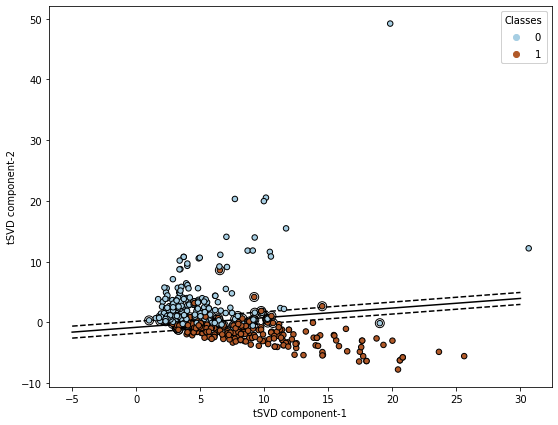

In [12]:
X=x_train_tSVD
y=y_train

w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-5, 30)
yy = a * xx - (clf.intercept_[0]) / w[1]
margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
yy_down = yy - np.sqrt(1 + a ** 2) * margin
yy_up = yy + np.sqrt(1 + a ** 2) * margin

fig, ax = plt.subplots(figsize=(9,7))
ax.plot(xx, yy, "k-")
ax.plot(xx, yy_down, "k-", linestyle='dashed')
ax.plot(xx, yy_up, "k-", linestyle='dashed')
scatter_1 = ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80,
 facecolors="none", zorder=10, edgecolors="k")
scatter_2 = ax.scatter(X[:, 0], X[:, 1], c=y,s=30, zorder=10, cmap=plt.cm.Paired,
 edgecolors="k")
ax.set_xlabel("tSVD component-1")
ax.set_ylabel("tSVD component-2")
legend1 = ax.legend(*scatter_2.legend_elements(), loc="upper right", title="Classes")
ax.add_artist(legend1)
plt.show()

We wanted to better visualise the decision surface of the model using a contour plot as below (where 0 class is tech, and 1 class is entertainment):

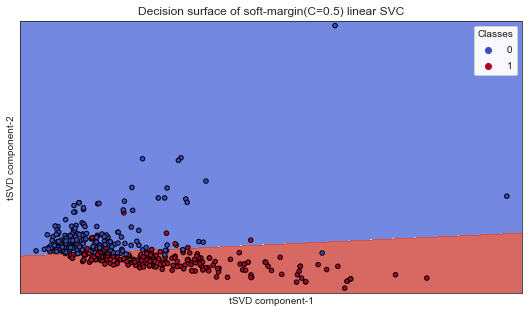

In [13]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out
  
X=x_train_tSVD
y=y_train
sns.set_style("white")
fig, ax = plt.subplots(figsize=(9,5))
# title for the plots
title = ('Decision surface of soft-margin(C=0.5) linear SVC')
# Set-up grid for plotting.
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
scatter = ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('tSVD component-2')
ax.set_xlabel('tSVD component-1')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
ax.add_artist(legend1)
plt.show()

Here we instantiate a hard-margin $(c=0.5)$ SVC, with rbf kernel, and fit it to our 2d training data 


In [14]:
#instantiate hard margin SVC, rbf kernel, and misclasification penalty C=5
clf_rbf = SVC(C=5.0, kernel='rbf', gamma='scale')
clf_rbf.fit(x_train_tSVD, y_train)
y_pred_rbf=clf_rbf.predict(x_test_tSVD)

#printing out some evaluation metrics for our model
print('Evaluation Metrics for Hard-Margin linear SVM')
print('----------------------------------------------')
print('Accuracy score: ' + str(accuracy_score(y_pred_rbf, y_test)))
print('F1 score: ' + str(f1_score(y_test, y_pred_rbf, average='macro')))
print('Recall score: ' + str(recall_score(y_test, y_pred_rbf, average='macro')))
print('Precision score: ' + str(precision_score(y_test, y_pred_rbf, average='macro')))

Evaluation Metrics for Hard-Margin linear SVM
----------------------------------------------
Accuracy score: 0.9433962264150944
F1 score: 0.9417155425219941
Recall score: 0.9391621129326047
Precision score: 0.94499815430048


Visualising the decision surface of the above model using a contour plot below (where 0 class is tech, and 1 class is entertainment):

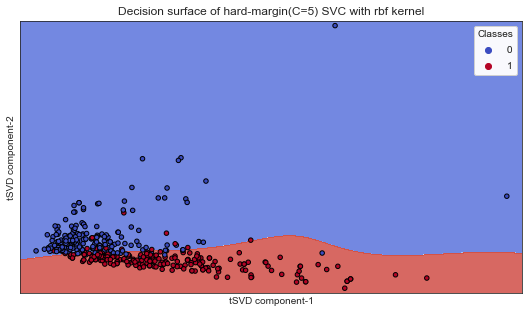

In [15]:
fig, ax = plt.subplots(figsize=(9,5))
# title for the plots
title = ('Decision surface of hard-margin(C=5) SVC with rbf kernel')
# Set-up grid for plotting.
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf_rbf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
scatter = ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('tSVD component-2')
ax.set_xlabel('tSVD component-1')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
ax.add_artist(legend1)
plt.show()

The impact of penalty C on soft-margin SVM controls the trade-off between maximizing the margin and minimizing the loss. A smaller value of C will create a small margin hyper-plane. 

The kernel hyperparameter in RBF $(σ)$ defines how smooth the decision boundary is. A higher kernel hyperparameter value means a smoother decision boundary. 


*Plot the average training cross-entropy loss as shown below on the y-axis versus the number of hidden units on the x-axis.*

As the of number of hidden layers increases, the training loss decreases because the amount of information gained by the model is lower, and this is because the model ends up overfitting instead of generalizing the training data.


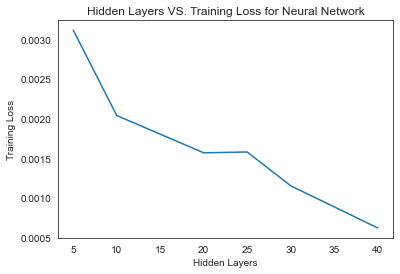

In [16]:
X_train = vectorizer.fit_transform(train_corpus.Text)
y_train = enc.fit_transform(train_corpus.Category)
h_layers = [5, 10 , 20, 25, 30, 40]
results = []
for i in range(len(h_layers)):
    NN = MLPClassifier(hidden_layer_sizes=(h_layers[i],), max_iter=100).fit(X_train,y_train)
    results.append(NN.loss_)
plt.plot(h_layers, results)
plt.title("Hidden Layers VS. Training Loss for Neural Network")
plt.xlabel("Hidden Layers")
plt.ylabel("Training Loss")
plt.show()


### Classification Models' Evaluation


*Explain the general trend of the two plots in terms of training and testing accuracy if any.*

As $m$ gets bigger there are more training examples for the models to generalize the problem space. As such, as $m$ increases the f-measure increases. Since the accuracy of the model increases, so does the precision and recall; this is reflected in the testing data graph where the f-measure increases as $m$ increases.

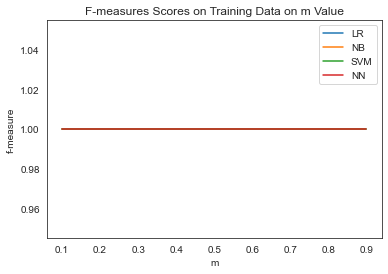

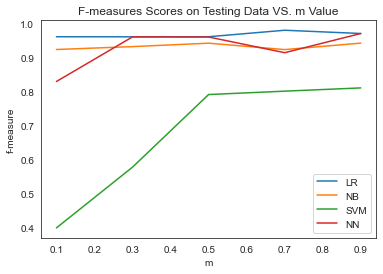

In [17]:
models = {
    'LR': LogisticRegression(),
    'NB': MultinomialNB(),
    'SVM': SVC(), 
    'NN': MLPClassifier()
}

model_parameters = {
    'LR': {'penalty': 'l2'},
    'NB': { 'alpha': 0},
    'SVM': { 'kernel': 'rbf'},
    'NN': { 'hidden_layer_sizes': 10, 'activation':  'relu', 'learning_rate_init': 0.01}
}

m = [0.1, 0.3, 0.5, 0.7, 0.9]
train_all_scores = []
test_all_scores = []

enc = LabelEncoder()
vectorizer = TfidfVectorizer()

for key in models:
    train_scores = []
    test_scores = []
    for i in range(len(m)):

        X, y = train_corpus['Text'], train_corpus['Category']
        X_train, _, y_train, _ = train_test_split(X, y, test_size = m[i], random_state=42)

        X_train = vectorizer.fit_transform(X_train)
        y_train = enc.fit_transform(y_train)

        X_test = vectorizer.transform(test_corpus.Text)
        y_test = enc.transform(test_corpus.Category)

        pipeline = make_pipeline(StandardScaler(with_mean=False), models[key].set_params(**model_parameters[key]))
        pipeline.fit(X_train, y_train)

        y_train_pred = pipeline.predict(X_train)
        y_test_pred = pipeline.predict(X_test)

        train_score = np.mean(f1_score(y_train_pred, y_train, average = None))
        test_score = np.mean(f1_score(y_test_pred,y_test, average = None))

        train_scores.append(train_score)
        test_scores.append(test_score)

    train_all_scores.append(train_scores)
    test_all_scores.append(test_scores)

m = m[::-1]
for i in range (len(train_all_scores)):
    if(i == 0):
        plt.plot(m,train_all_scores[i], label = 'LR')
    elif(i == 1):
        plt.plot(m,train_all_scores[i], label = 'NB')
    elif(i == 2):
        plt.plot(m,train_all_scores[i], label = 'SVM')
    elif(i == 3):
        plt.plot(m,train_all_scores[i], label = 'NN')

plt.title('F-measures Scores on Training Data on m Value')
plt.xlabel('m')
plt.ylabel('f-measure')
plt.legend()
plt.show()

for i in range (len(test_all_scores)):
    if(i == 0):
        plt.plot(m,test_all_scores[i], label = 'LR')
    elif(i == 1):
        plt.plot(m,test_all_scores[i], label = 'NB')
    elif(i == 2):
        plt.plot(m,test_all_scores[i], label = 'SVM')
    elif(i == 3):
        plt.plot(m,test_all_scores[i], label = 'NN')

plt.title('F-measures Scores on Testing Data VS. m Value')
plt.xlabel('m')
plt.ylabel('f-measure')
plt.legend()
plt.show()


*List hyperparameters for each classifier and demonstrate how these hyperparameters impact on the testing accuracy.*



In [18]:
vectorizer = TfidfVectorizer()
tSVD=TruncatedSVD(n_components=20)
enc = LabelEncoder()

X_train = vectorizer.fit_transform(train_corpus.Text)
y_train = enc.fit_transform(train_corpus.Category)

X_test = vectorizer.transform(test_corpus.Text)
y_test = enc.transform(test_corpus.Category)

def task_3_b(pipe, X_train, y_train, X_test, y_test):
    pipe.fit(X_train, y_train)
    print('Test Accuracy: %.3f' % pipe.score(X_test, y_test), '\nTrain Accuracy: %.3f' % pipe.score(X_train, y_train))
    print()
    kfold = StratifiedKFold().split(X_train, y_train)
    scores = []
    for k, (train, test) in enumerate(kfold):
        pipe.fit(X_train[train], y_train[train])
        score = pipe.score(X_train[test], y_train[test])
        scores.append(score)
        print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1,
              np.bincount(y_train[train]), score))
    print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
    print('-' * 50)    

# SVM
kernels = ['linear', 'rbf', 'poly']
C = [1, 3, 10]
X_train_SVD = tSVD.fit_transform(X_train)
X_test_SVD = tSVD.transform(X_test)
for kernel in kernels:
    for C_value in C:
        print(f'Kernel: {kernel} \nC: {C_value}\n')
        pipe_svm = make_pipeline(StandardScaler(with_mean=False), SVC(kernel=kernel, C=C_value))
        task_3_b(pipe_svm, X_train_SVD, y_train, X_test_SVD, y_test)

# LINEAR REGRESSION
C_LR = [0.01, 0.1, 1, 10, 100]
for C in C_LR:
    print(f'Linear Regression, C: {C}\n')
    pipe_LR = make_pipeline(StandardScaler(with_mean=False), LogisticRegression(C = C))
    task_3_b(pipe_LR, X_train, y_train, X_test, y_test)
    
# NN
h_layers = [5, 10 , 20, 25, 30]
for h in h_layers:
    print(f'Neural Network, layers: {h}\n')
    pipe_NN = make_pipeline(StandardScaler(with_mean=False), MLPClassifier(hidden_layer_sizes=(h,), max_iter=100))
    task_3_b(pipe_NN, X_train, y_train, X_test, y_test)

# Naive Bayes
alpha = [2, 4, 6, 8, 10]
for a in alpha:
    print(f'Naive Bayes, alpha: {a}\n')
    pipe_NB = make_pipeline(StandardScaler(with_mean=False), MultinomialNB(alpha = a))
    task_3_b(pipe_NB, X_train, y_train, X_test, y_test)

Kernel: linear 
C: 1

Test Accuracy: 0.972 
Train Accuracy: 0.986

Fold:  1, Class dist.: [170 172], Acc: 0.977
Fold:  2, Class dist.: [169 173], Acc: 0.965
Fold:  3, Class dist.: [169 173], Acc: 0.977
Fold:  4, Class dist.: [170 173], Acc: 0.965
Fold:  5, Class dist.: [170 173], Acc: 0.976

CV accuracy: 0.972 +/- 0.006
--------------------------------------------------
Kernel: linear 
C: 3

Test Accuracy: 0.981 
Train Accuracy: 0.995

Fold:  1, Class dist.: [170 172], Acc: 0.988
Fold:  2, Class dist.: [169 173], Acc: 0.965
Fold:  3, Class dist.: [169 173], Acc: 0.977
Fold:  4, Class dist.: [170 173], Acc: 0.976
Fold:  5, Class dist.: [170 173], Acc: 0.976

CV accuracy: 0.977 +/- 0.007
--------------------------------------------------
Kernel: linear 
C: 10

Test Accuracy: 0.981 
Train Accuracy: 0.998

Fold:  1, Class dist.: [170 172], Acc: 0.977
Fold:  2, Class dist.: [169 173], Acc: 0.965
Fold:  3, Class dist.: [169 173], Acc: 0.977
Fold:  4, Class dist.: [170 173], Acc: 0.965
Fold: 


*compare your LR, NB, SVM, and NN classifiers with the best hyperparameter settings. Summarize what you have observed in the classification accuracy in measure on $𝐹1$ the testing dataset.*

We ran our models based on the tuned hyperparameters from the above task and in that instance recorded:

*   Linear regression: $C = 10$
*   Naive Bayes: $Alpha = 4$
*   SVM (RBF): $C = 3$
*   Neural network: $Layers = 10$

With these better-tuned hyperparameters, the f-measure is better than the prior hyperparameters we used. All 4 models perform quite similarly. The SVM and LR have the highest and an identical f-measure.


In [19]:
X_train = vectorizer.fit_transform(train_corpus.Text)
y_train = enc.fit_transform(train_corpus.Category)

X_test = vectorizer.transform(test_corpus.Text)
y_test = enc.transform(test_corpus.Category)

#LRM with best hyperparameters
LR = LogisticRegression(C=10)
LR.fit(X_train, y_train)
y_pred=LR.predict(X_test)
f_score = f1_score(y_test,y_pred, average='macro')
print(f'F1 Score of LR(C=10): {f_score}')

#NB with best hyperparameters
NB = MultinomialNB(alpha=4)
NB.fit(X_train, y_train)
y_pred=NB.predict(X_test)
f_score = f1_score(y_test,y_pred, average='macro')
print(f'F1 Score of NB(alpha=4): {f_score}')

#SVM with best hyperparameters
SVM = SVC(kernel='rbf', C=3)
SVM.fit(X_train, y_train)
y_pred=SVM.predict(X_test)
f_score = f1_score(y_test,y_pred, average='macro')
print(f'F1 Score of SVM(rbf,C=3): {f_score}')

#NN with best hyperparameters
NN = MLPClassifier(hidden_layer_sizes=(10,), max_iter=100)
NN.fit(X_train, y_train)
y_pred=NN.predict(X_test)
f_score = f1_score(y_test,y_pred, average='macro')
print(f'F1 Score of NN(hidden_layer_sizes=(10,)): {f_score}')

F1 Score of LR(C=10): 0.9903732631005359
F1 Score of NB(alpha=4): 0.9712659257251288
F1 Score of SVM(rbf,C=3): 0.9903732631005359
F1 Score of NN(hidden_layer_sizes=(10,)): 1.0
